**<center><p style="font-size:40px;">Classification des IRM cérébrales pour la détection de la démence</p></center>**

**Présentation du projet**


>Ce projet vise à classifier des images d'IRM cérébrales en différentes catégories en fonction de la présence et du degré de démence (un syndrome qui désigne une dégradation progressive des fonctions cognitives, affectant la mémoire et le raisonnement).

**Objectif**

>L'objectif principal de ce travail est de développer et d'évaluer plusieurs modèles d'apprentissage profond, notamment un réseau de neurones convolutif (CNN) personnalisé, ainsi que des modèles pré-entraînés tels que VGG et GoogleNet (InceptionV3), afin de classer avec précision les images cérébrales dans leurs catégories respectives : NonDemented, VeryMildDemented, MildDemented, et ModerateDemented.

>Ce projet vise à contribuer à la détection précoce de la démence, ce qui pourrait grandement aider au diagnostic médical et à la prise en charge des patients.

**Approche**

>Prétraitement des données (des images IRM).

>Implémentation des modèles.

>Évaluation : Comparaison des performances des modèles à l’aide de métriques.


In [2]:
import os
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from PIL import Image, ImageOps
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
from sklearn.preprocessing import LabelEncoder
import random
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.applications import VGG16
from tensorflow.keras.layers import GlobalAveragePooling2D
from tensorflow.keras.applications import InceptionV3
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.optimizers import Adam

### **Visualisation de la distribution des classes :**

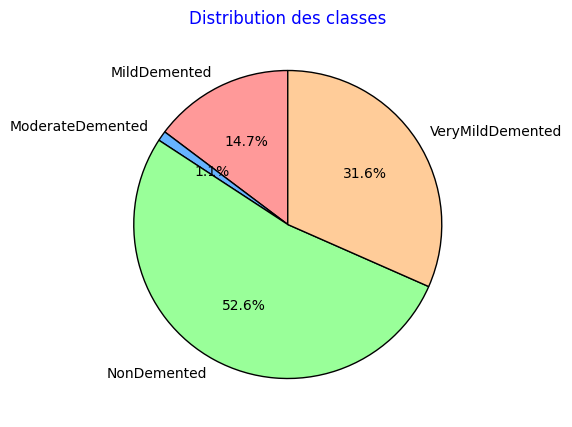

In [3]:
path = r"C:\Users\Skouza\Desktop\Atelier\Alzheimer_s Dataset\data"
classes = ['MildDemented', 'ModerateDemented', 'NonDemented', 'VeryMildDemented']
class_counts = {}
for cls in classes:
    class_path = os.path.join(path, cls)
    class_counts[cls] = len(os.listdir(class_path))

plt.figure(figsize=(5, 5)) 
plt.pie(
    class_counts.values(), 
    labels=class_counts.keys(), 
    autopct='%1.1f%%',  
    startangle=90, 
    colors=['#ff9999','#66b3ff','#99ff99','#ffcc99'],  
    wedgeprops={'edgecolor': 'black'},
     
)
plt.title('Distribution des classes',color='blue')
plt.show()

>  le déséquilibre des classes n'est pas si critique qu'il nécessite une intervention via la data augmentation.

### **Affichage d'échantillons d'images :**

In [4]:
#Analyse des dimensions des images :
shapes = {}
for cls in classes:
    sample_path = os.path.join(path, cls, os.listdir(os.path.join(path, cls))[0])
    img = Image.open(sample_path)
    shapes[cls] = img.size
    print(f"{cls}: {shapes[cls]}")

MildDemented: (176, 208)
ModerateDemented: (176, 208)
NonDemented: (176, 208)
VeryMildDemented: (176, 208)


> Toutes les classes ont les mêmes dimensions d’images (176, 208)

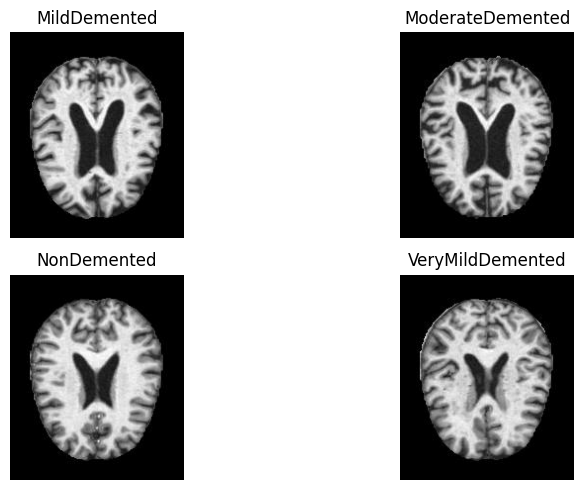

In [5]:
plt.figure(figsize=(10, 5))
for i, cls in enumerate(classes):
    sample_path = os.path.join(path, cls, os.listdir(os.path.join(path, cls))[0])
    img = Image.open(sample_path)
    plt.subplot(2, 2, i+1)
    plt.imshow(img,cmap='gray')
    plt.title(cls)
    plt.axis('off')
plt.tight_layout()
plt.show()

>**Cerveau non dement :** L'image IRM montre une structure cérébrale normale. Les régions du cerveau apparaissent intactes et bien définies.

>**Cerveau dement :** L'image IRM montre une atrophie cérébrale significative avec un rétrécissement marqué des régions cérébrales et un élargissement notable des ventricules(zones sombres).

### **Transformation et comparaison**

In [6]:
def select_random_image(dataset_path):
    all_images = []
    for root, dirs, files in os.walk(dataset_path):
        for file in files:
            if file.endswith(('.png', '.jpg', '.jpeg')):
                all_images.append(os.path.join(root, file))
    return random.choice(all_images)

def rotate_image(image, degrees=45):
    return image.rotate(degrees, expand=True)

def add_random_noise(image, intensity):
    img_array = np.array(image)
    noise = np.random.normal(0, intensity*255, img_array.shape)
    noisy_array = img_array + noise
    return Image.fromarray(np.clip(noisy_array, 0, 255).astype(np.uint8))

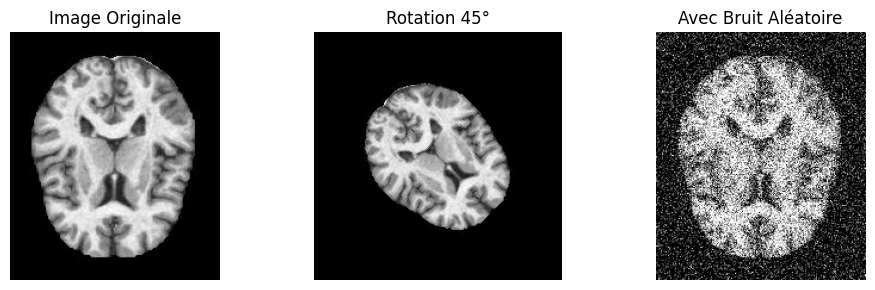

In [7]:
random_image_path = select_random_image(path)
original_image = Image.open(random_image_path)
rotated_image = rotate_image(original_image)
noisy_image = add_random_noise(original_image,0.3)

plt.figure(figsize=(10, 3))
plt.subplot(1, 3, 1)
plt.imshow(original_image, cmap='gray')
plt.title('Image Originale')
plt.axis('off')
plt.subplot(1, 3, 2)
plt.imshow(rotated_image, cmap='gray')
plt.title('Rotation 45°')
plt.axis('off')
plt.subplot(1, 3, 3)
plt.imshow(noisy_image, cmap='gray')
plt.title('Avec Bruit Aléatoire')
plt.axis('off')
plt.tight_layout()
plt.show()

>   Les IRM cérébrales sont des données médicales sensibles. Toute transformation risque d'altérer des caractéristiques essentielles au diagnostic de la démence. La "data augmentation" pourrait introduire des artefacts ou masquer des signaux subtils, affectant ainsi l'apprentissage du modèle.

![erreur](images/Classification%20Metrics%20Formulas.jpg)

### **Préparation des données**

In [33]:
# Data preprocessing
datagen = ImageDataGenerator(rescale=1./255, validation_split=0.2)
train_generator = datagen.flow_from_directory(
    path, target_size=(224, 224), batch_size=32, class_mode='categorical', subset='training')
val_generator = datagen.flow_from_directory(
    path, target_size=(224, 224), batch_size=32, class_mode='categorical', subset='validation')
num_classes = len(train_generator.class_indices)

Found 4867 images belonging to 4 classes.
Found 1215 images belonging to 4 classes.


### **Création des modèles**

**CNN**

In [24]:
def create_cnn_model():
    model = Sequential([
        Conv2D(32, (3,3), activation='relu', padding='same', input_shape=(224, 224, 3)),
        MaxPooling2D(2,2),
        Conv2D(64, (3,3), activation='relu', padding='same'),
        MaxPooling2D(2,2),
        Flatten(),
        Dense(128, activation='relu'),
        Dropout(0.5),
        Dense(num_classes, activation='softmax')
    ])
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    return model

**VGG pré-entraîné**

In [25]:
def create_vgg_model():
    base_model = VGG16(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
    base_model.trainable = False
    model = Sequential([
        base_model,
        Flatten(),
        Dense(128, activation='relu'),
        Dropout(0.5),
        Dense(num_classes, activation='softmax')
    ])
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    return model

**GoogleNet (InceptionV3) pré-entraîné**

In [26]:
def create_inception_model():
    base_model = InceptionV3(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
    base_model.trainable = False
    model = Sequential([
        base_model,
        Flatten(),
        Dense(128, activation='relu'),
        Dropout(0.5),
        Dense(num_classes, activation='softmax')
    ])
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    return model

### **Entraînement des modèles et collecte des métriques**

In [37]:
def train_and_evaluate(model, model_name):
    history = model.fit(train_generator, validation_data=val_generator, epochs=10, verbose=1)
    
    # Plot Accuracy and Loss
    plt.figure(figsize=(12, 5))
    
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Train Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.title(f'{model_name} Accuracy')
    plt.legend()
    
    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title(f'{model_name} Loss')
    plt.legend()
    
    plt.show()

    # Evaluate on validation set
    y_true, y_pred, y_scores = [], [], []
    for images, labels in val_generator:
        preds = model.predict(images)
        y_scores.extend(preds)
        y_pred.extend(np.argmax(preds, axis=1))
        y_true.extend(np.argmax(labels, axis=1))
        if len(y_true) >= val_generator.samples:
            break
    
    # Compute metrics
    metrics[model_name]["accuracy"].append(accuracy_score(y_true, y_pred))
    metrics[model_name]["precision"].append(precision_score(y_true, y_pred, average='macro'))
    metrics[model_name]["recall"].append(recall_score(y_true, y_pred, average='macro'))
    metrics[model_name]["f1"].append(f1_score(y_true, y_pred, average='macro'))
    metrics[model_name]["auc"].append(roc_auc_score(y_true, np.array(y_scores), multi_class='ovr'))

In [27]:
metrics = {"CNN": {"accuracy": [], "precision": [], "recall": [], "f1": [], "auc": []},
           "VGG": {"accuracy": [], "precision": [], "recall": [], "f1": [], "auc": []},
           "Inception": {"accuracy": [], "precision": [], "recall": [], "f1": [], "auc": []}}

Epoch 1/10


c:\Users\Skouza\Desktop\Atelier\venv\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


153/153 ━━━━━━━━━━━━━━━━━━━━ 49s 316ms/step - accuracy: 0.4877 - loss: 1.6940 - val_accuracy: 0.5309 - val_loss: 1.0651
Epoch 2/10
153/153 ━━━━━━━━━━━━━━━━━━━━ 49s 321ms/step - accuracy: 0.6618 - loss: 0.7470 - val_accuracy: 0.5753 - val_loss: 1.0731
Epoch 3/10
153/153 ━━━━━━━━━━━━━━━━━━━━ 48s 313ms/step - accuracy: 0.8077 - loss: 0.4666 - val_accuracy: 0.5473 - val_loss: 1.0979
Epoch 4/10
153/153 ━━━━━━━━━━━━━━━━━━━━ 49s 321ms/step - accuracy: 0.8928 - loss: 0.2953 - val_accuracy: 0.5942 - val_loss: 1.2294
Epoch 5/10
153/153 ━━━━━━━━━━━━━━━━━━━━ 49s 322ms/step - accuracy: 0.9255 - loss: 0.1936 - val_accuracy: 0.5975 - val_loss: 1.4714
Epoch 6/10
153/153 ━━━━━━━━━━━━━━━━━━━━ 49s 319ms/step - accuracy: 0.9545 - loss: 0.1290 - val_accuracy: 0.5984 - val_loss: 1.9019
Epoch 7/10
153/153 ━━━━━━━━━━━━━━━━━━━━ 49s 321ms/step - accuracy: 0.9594 - loss: 0.1168 - val_accuracy: 0.5424 - val_loss: 2.2785
Epoch 8/10
153/153 ━━━━━━━━━━━━━━━━━━━━ 49s 320ms/step - accuracy: 0.9647 - loss: 0.0961 - val

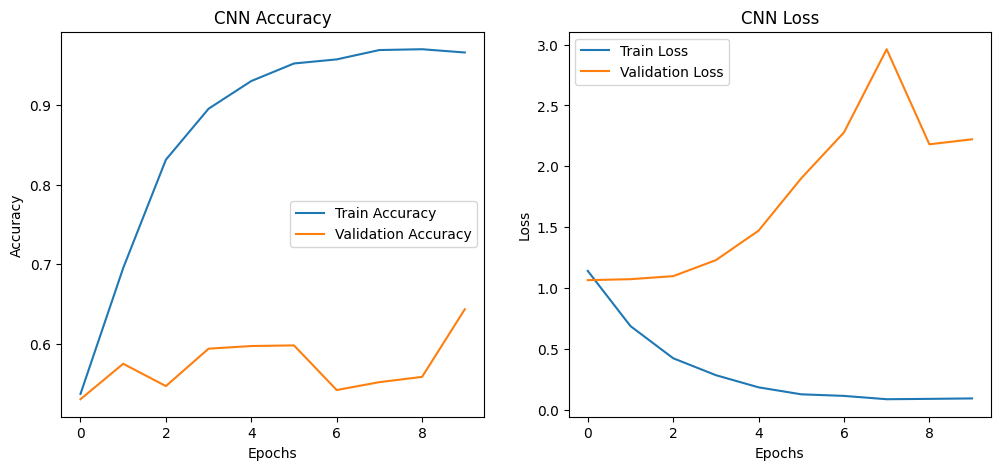

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 117ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 97ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 107ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 94ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 91ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 104ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 93ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 90ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 90ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 90ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 92ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 92ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step
1/1 ━━━━━

c:\Users\Skouza\Desktop\Atelier\venv\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [38]:
train_and_evaluate(create_cnn_model(),"CNN")

> Le modèle CNN montre une amélioration de la précision et une réduction de la perte au fil des époques, indiquant un apprentissage efficace. Cependant, l'écart entre la précision d'entraînement et de validation suggère un léger surajustement.

Epoch 1/10
153/153 ━━━━━━━━━━━━━━━━━━━━ 294s 2s/step - accuracy: 0.4632 - loss: 1.7584 - val_accuracy: 0.5267 - val_loss: 0.9327
Epoch 2/10
153/153 ━━━━━━━━━━━━━━━━━━━━ 393s 3s/step - accuracy: 0.5056 - loss: 0.9869 - val_accuracy: 0.5317 - val_loss: 0.9243
Epoch 3/10
153/153 ━━━━━━━━━━━━━━━━━━━━ 287s 2s/step - accuracy: 0.5257 - loss: 0.9280 - val_accuracy: 0.5449 - val_loss: 0.8878
Epoch 4/10
153/153 ━━━━━━━━━━━━━━━━━━━━ 281s 2s/step - accuracy: 0.5322 - loss: 0.8990 - val_accuracy: 0.5547 - val_loss: 0.8756
Epoch 5/10
153/153 ━━━━━━━━━━━━━━━━━━━━ 289s 2s/step - accuracy: 0.5597 - loss: 0.8606 - val_accuracy: 0.5819 - val_loss: 0.8796
Epoch 6/10
153/153 ━━━━━━━━━━━━━━━━━━━━ 294s 2s/step - accuracy: 0.5504 - loss: 0.8468 - val_accuracy: 0.5934 - val_loss: 0.8611
Epoch 7/10
153/153 ━━━━━━━━━━━━━━━━━━━━ 295s 2s/step - accuracy: 0.5854 - loss: 0.7925 - val_accuracy: 0.6025 - val_loss: 0.8229
Epoch 8/10
153/153 ━━━━━━━━━━━━━━━━━━━━ 291s 2s/step - accuracy: 0.5842 - loss: 0.7993 - val_accu

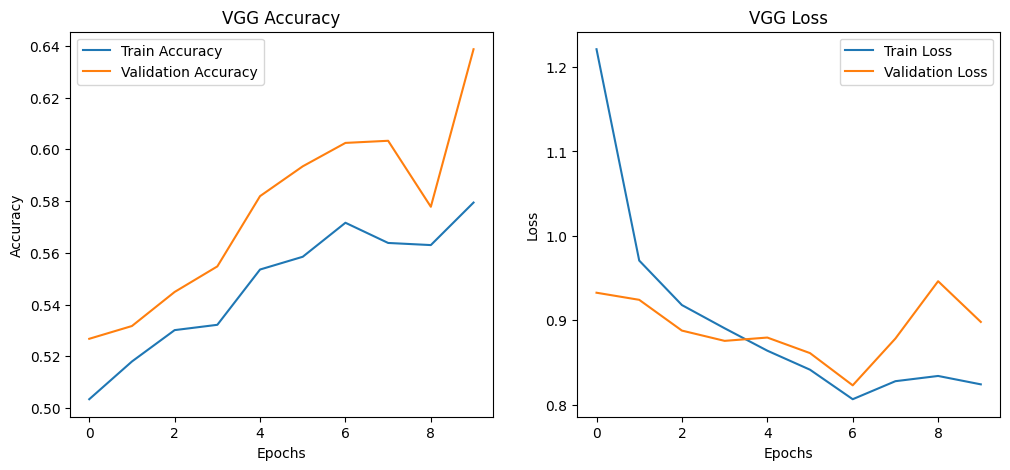

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 

c:\Users\Skouza\Desktop\Atelier\venv\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [40]:
train_and_evaluate(create_vgg_model(), "VGG")

> Les résultats pour le modèle VGG montrent une précision d'entraînement et de validation qui augmente légèrement au fil des époques, mais reste relativement basse, indiquant une performance modérée.

87910968/87910968 ━━━━━━━━━━━━━━━━━━━━ 52s 1us/step
Epoch 1/10
153/153 ━━━━━━━━━━━━━━━━━━━━ 89s 553ms/step - accuracy: 0.4719 - loss: 7.6438 - val_accuracy: 0.5267 - val_loss: 1.1044
Epoch 2/10
153/153 ━━━━━━━━━━━━━━━━━━━━ 80s 524ms/step - accuracy: 0.5278 - loss: 1.1417 - val_accuracy: 0.5267 - val_loss: 1.0495
Epoch 3/10
153/153 ━━━━━━━━━━━━━━━━━━━━ 90s 590ms/step - accuracy: 0.5229 - loss: 1.0868 - val_accuracy: 0.5267 - val_loss: 1.0521
Epoch 4/10
153/153 ━━━━━━━━━━━━━━━━━━━━ 90s 586ms/step - accuracy: 0.5230 - loss: 1.0609 - val_accuracy: 0.5267 - val_loss: 0.9845
Epoch 5/10
153/153 ━━━━━━━━━━━━━━━━━━━━ 84s 552ms/step - accuracy: 0.5309 - loss: 1.0225 - val_accuracy: 0.5267 - val_loss: 0.9838
Epoch 6/10
153/153 ━━━━━━━━━━━━━━━━━━━━ 77s 506ms/step - accuracy: 0.5188 - loss: 1.0069 - val_accuracy: 0.5267 - val_loss: 1.1025
Epoch 7/10
153/153 ━━━━━━━━━━━━━━━━━━━━ 79s 519ms/step - accuracy: 0.5227 - loss: 1.0015 - val_accuracy: 0.5267 - val_loss: 0.9807
Epoch 8/10
153/153 ━━━━━━━━━━━━

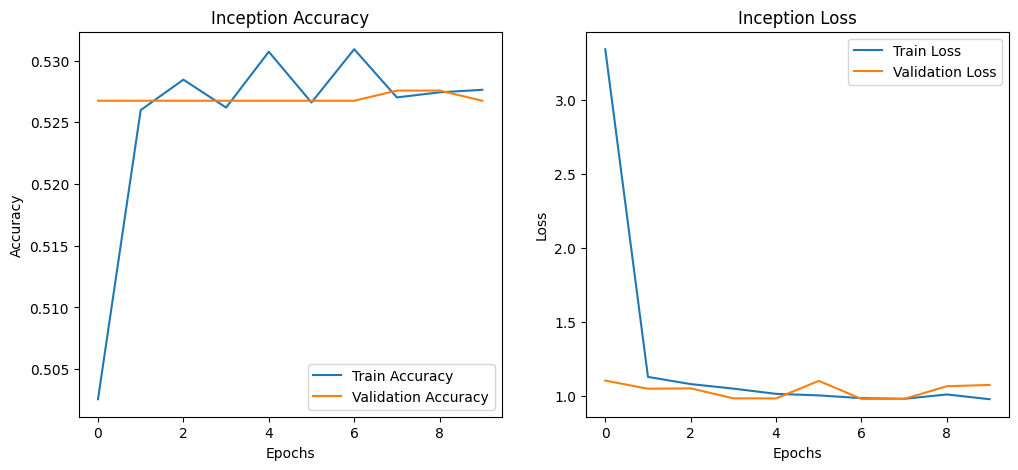

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 436ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 454ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 495ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 456ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 413ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 433ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 418ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 424ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 408ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 413ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 450ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 421ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 415ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 428ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 453ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 428ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 449ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 428ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 443ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 441ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 421ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 432ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 449ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 458ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 

c:\Users\Skouza\Desktop\Atelier\venv\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [41]:
train_and_evaluate(create_inception_model(), "Inception")

> Le modèle peine à améliorer l'exactitude de validation.

> L'absence de diminution significative de la perte de validation montre que le modèle ne parvient pas à apprendre.

### **Comparaison des Performances avec des Boxplots**

In [43]:
models_dict = {"CNN": create_cnn_model(), "VGG": create_vgg_model(), "Inception": create_inception_model()}

c:\Users\Skouza\Desktop\Atelier\venv\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


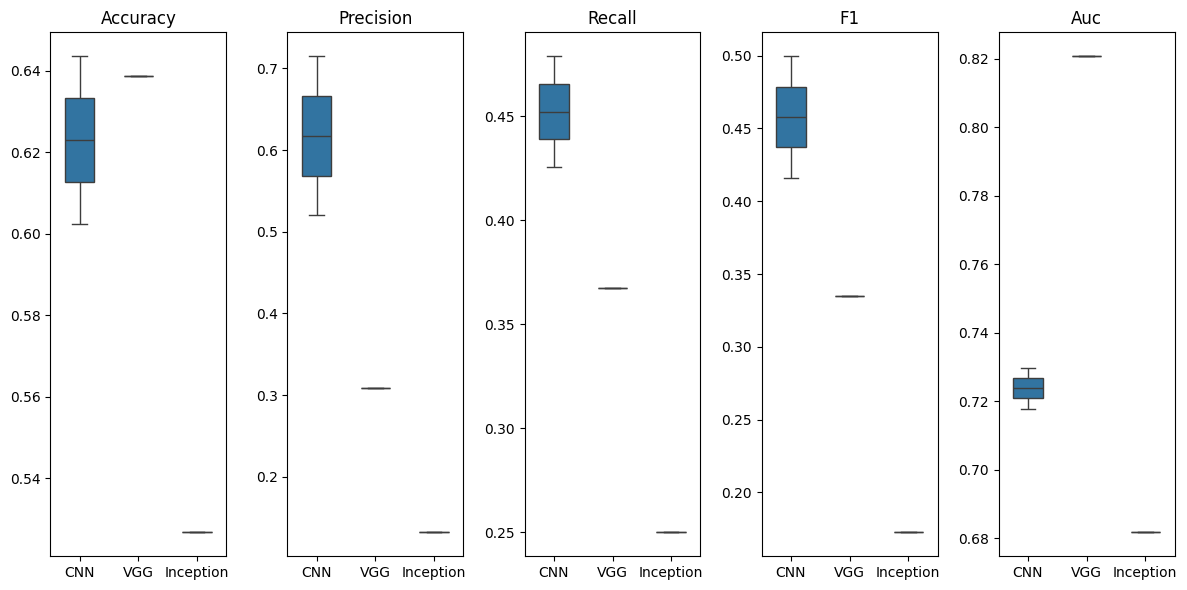

In [44]:
# Boxplots for metric comparison
plt.figure(figsize=(12, 6))
for i, metric in enumerate(["accuracy", "precision", "recall", "f1", "auc"], 1):
    plt.subplot(1, 5, i)
    sns.boxplot(data=[metrics[model][metric] for model in models_dict], width=0.5)
    plt.xticks(range(len(models_dict)), models_dict.keys())
    plt.title(metric.capitalize())
plt.tight_layout()
plt.show()

> Conclusion :

>VGG semble globalement être le modèle le plus fiable grâce à sa meilleure accuracy et son AUC élevé.

>CNN offre de bons résultats en précision, rappel et F1-score, ce qui peut être utile selon l'objectif.

>Inception sous-performe dans tous les critères, indiquant qu'il n'est pas adapté à ce problème.